# Multi-Class Classification with Neural Network

## Import Libraries

In [95]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs #creates isotropic Gaussian blobs of data for clustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


## Set Hyperparameters for Data Creation

In [78]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


## Create Multi-Class Data

In [79]:
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, #controls the data blob spread
                            random_state = RANDOM_SEED)

## Convert Our Data to Tensors

In [80]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

## Split Data into Training and Test Sets

In [81]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

## Visualize Toy-Data Training Set

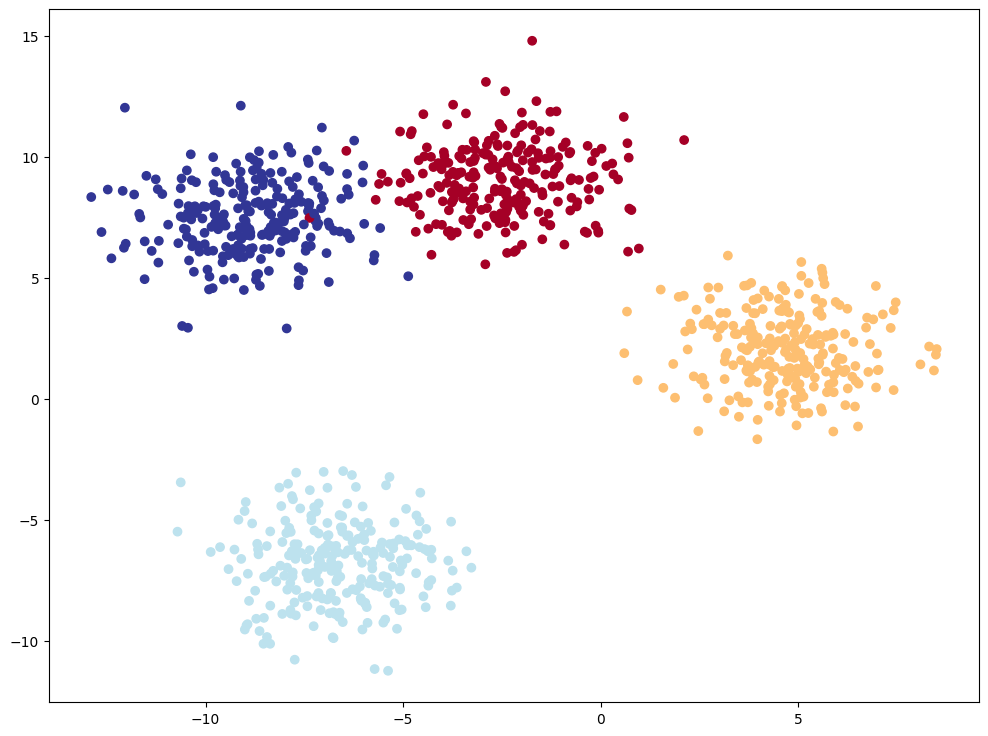

In [82]:
plt.figure(figsize = (12,9))
plt.scatter( X_blob[:,0],
           X_blob[:,1],
           c = y_blob,
           cmap = plt.cm.RdYlBu)
plt.show()

## Establish Device Agnostic Code

In [83]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

## Build Multi Class Classification Model

In [84]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)

    )

  def forward(self,x):
    return self.linear_layer_stack(x)

## Instantiate the Model

In [85]:
model_4 = BlobModel(input_features = 2, output_features = 4, hidden_units = 8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Create a Loss Function and Optimizer

In [86]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

## Get Predictions using the Untrained Model

In [87]:
model_4.eval()

with torch.inference_mode():
  untrained_logits = model_4(X_blob_test.to(device))

In [88]:
untrained_logits[:10] #predictions are output as raw logits

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [89]:
untrained_preds = torch.softmax(untrained_logits, dim = 1)
untrained_preds[:10] #Here we can see the logits have been converted to prediction probabilities after processing through softmax


tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463],
        [0.3381, 0.1358, 0.1929, 0.3331],
        [0.2867, 0.1841, 0.2861, 0.2431],
        [0.3554, 0.1355, 0.1740, 0.3351],
        [0.3009, 0.1841, 0.2779, 0.2371],
        [0.3595, 0.1350, 0.1695, 0.3360]])

### Understanding the prediction probabilities

*   Each inner list represents a single data point
*   Each data point is evaulated with four distinct probabilities
*   The first probabiity is the probability of the data point belonging to group 0
*   The second probability is the probability of the data point belonging to group 1 (and so on)
* The group each data point most likely belongs to is the index of the maximum value in each inner list (we can produce this with torch.argmax())



## Convert Prediction Probabilities to Prediction Labels

In [90]:
pred_labels = torch.argmax(untrained_preds, dim = 1)
pred_labels[:10] #we now have output in the format of what group the model believes each datapoint belongs within
                 #However, the model is still untrained so all of these values are likely inaccurate

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Create an Accuracy Function

In [91]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() #.eq() evaluates whether the values fed to it are equal.
                                                 #This chaining give us the sum of instances where the prediction is equal to the real value and returns it to us as a single number
  accuracy = (correct/len(y_pred)) * 100
  return accuracy # we return the percentage of accurate predictions

## Create a Training and Testing Loop for the Multi-Class Model

In [92]:
#fit multi-class model to the data

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set Number of Epochs

epochs = 100

#Send each data set to device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

#loop through data

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train).to(device)
  y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Entering testing mode
  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_blob_test).to(device)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc} ")


Epoch: 0, Loss: 1.1588267087936401, Accuracy: 40.375, Test Loss: 1.0755422115325928, Test Accuracy: 48.0 
Epoch: 10, Loss: 0.6447553038597107, Accuracy: 96.75, Test Loss: 0.660687267780304, Test Accuracy: 97.5 
Epoch: 20, Loss: 0.4253515303134918, Accuracy: 98.5, Test Loss: 0.43074119091033936, Test Accuracy: 100.0 
Epoch: 30, Loss: 0.2529422640800476, Accuracy: 99.125, Test Loss: 0.24507610499858856, Test Accuracy: 99.5 
Epoch: 40, Loss: 0.11232147365808487, Accuracy: 99.25, Test Loss: 0.10228512436151505, Test Accuracy: 99.5 
Epoch: 50, Loss: 0.06626509130001068, Accuracy: 99.25, Test Loss: 0.058475371450185776, Test Accuracy: 99.5 
Epoch: 60, Loss: 0.05068016052246094, Accuracy: 99.25, Test Loss: 0.042932283133268356, Test Accuracy: 99.5 
Epoch: 70, Loss: 0.04299675300717354, Accuracy: 99.25, Test Loss: 0.034909654408693314, Test Accuracy: 99.5 
Epoch: 80, Loss: 0.038361385464668274, Accuracy: 99.25, Test Loss: 0.02987821027636528, Test Accuracy: 99.5 
Epoch: 90, Loss: 0.03524842858

## Visualize Predictions with Helper Function
 #### We first download the function

In [93]:
import requests
from pathlib import Path

# helper function downloaded from Learn PyTorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")

else:
  print("downloading helper_functions.py")

  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

  from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


#### We then plot the decision boundaries

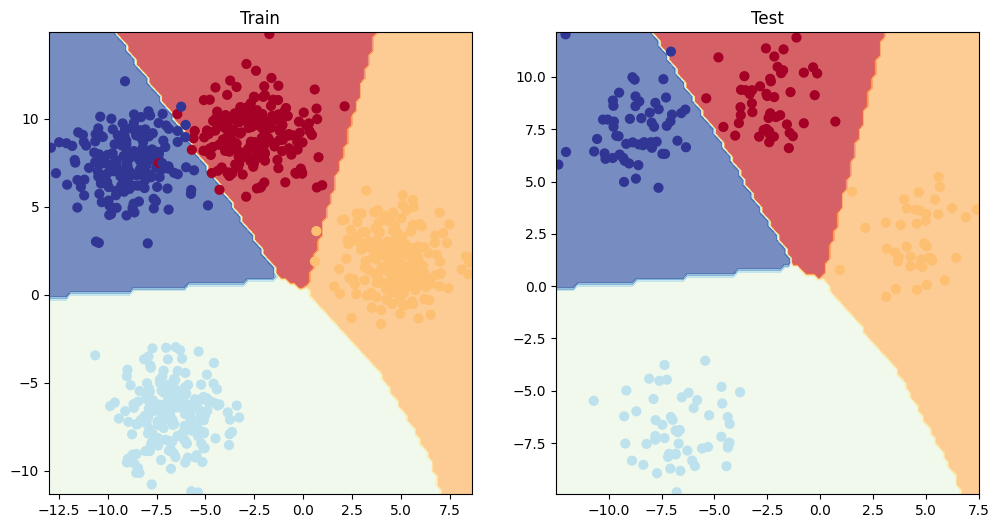

In [94]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

## Represent Predicted Class vs. True Class with a Confusion Matrix

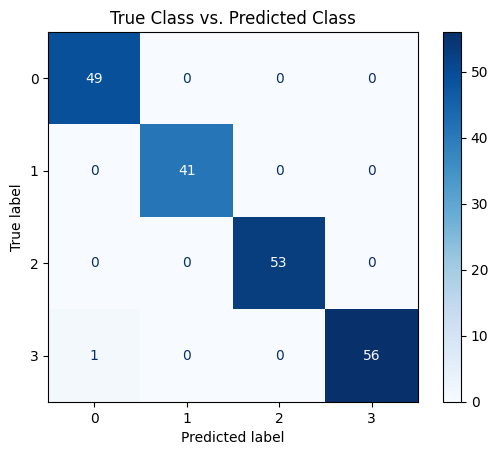

In [106]:
y_true = y_blob_test.to(torch.int64).to(device)
y_pred = test_preds.to(device)

# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("True Class vs. Predicted Class")
plt.show()